In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, cv2, pickle, json, itertools
import imgaug.augmenters as iaa
import imgaug.imgaug

from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *
import glob
import json

In [2]:
ships_data = pd.read_json(r"C:\Users\gabri\OneDrive\Documentos\Projects\ships_class\labels.json")

In [3]:
print(max(np.concatenate(ships_data.data.values)))
print(min(np.concatenate(ships_data.data.values)))

255
1


In [4]:
#normalise data for convergence 
ships_data['data']=ships_data['data'].apply(lambda x: np.array(x).reshape(3,80,80).transpose(1,2,0)) #unflatten
ships_data["normalised_data1"] = ships_data["data"].apply(lambda x : np.array(x)/255)

In [5]:
array_ships=np.stack(ships_data[ships_data['labels']==1]['normalised_data1'])
array_noships=np.stack(ships_data[ships_data['labels']==0]['normalised_data1'])


# Individual histograms of pictures without ships 

In [6]:
random.seed(30)
ids_list=random.sample(range(len(array_noships)), k=10)

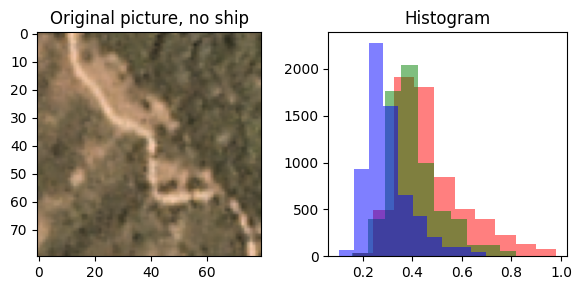

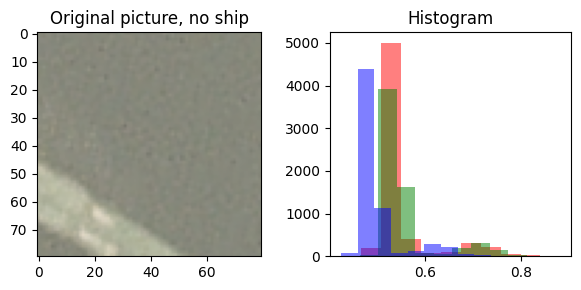

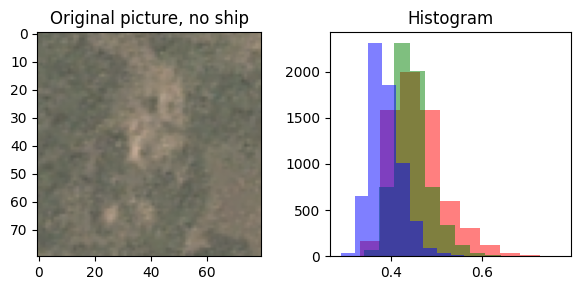

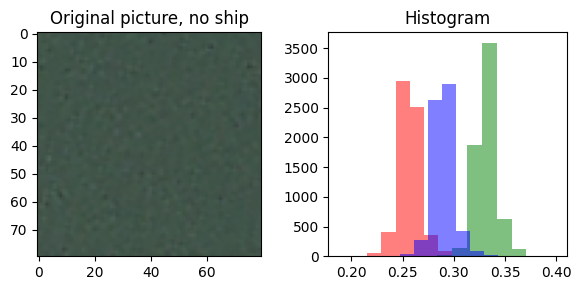

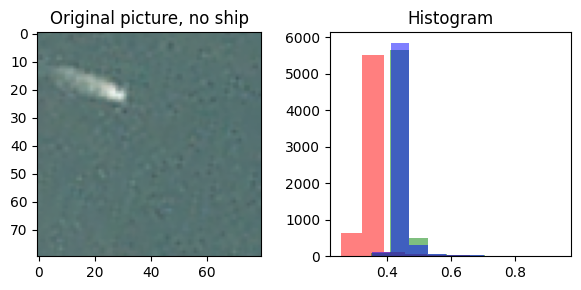

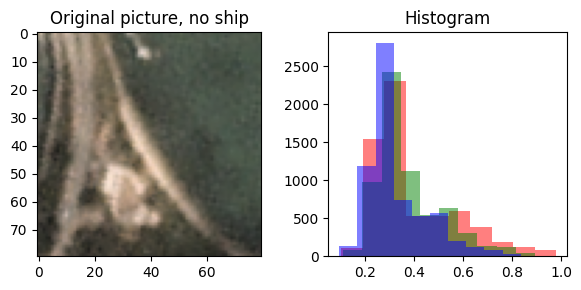

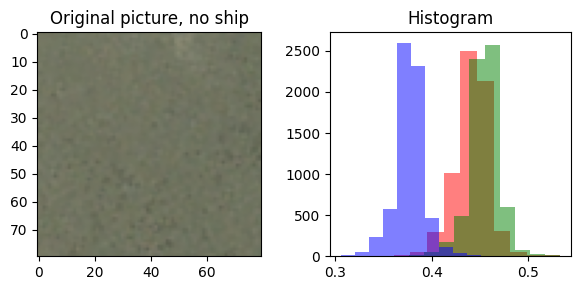

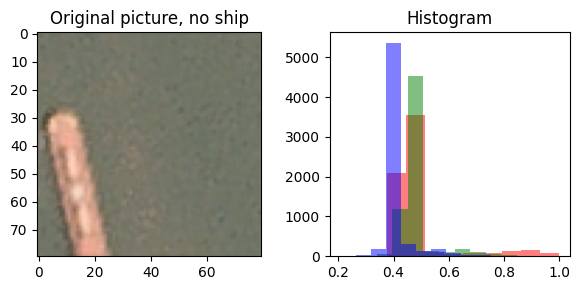

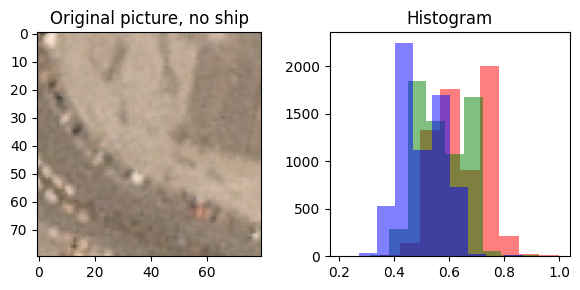

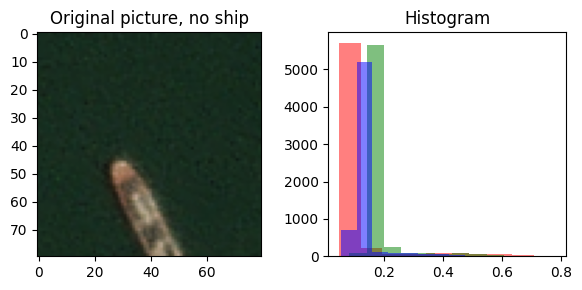

In [7]:

#plot random images, otherwsie it is too long 

random.seed(30)
ids_list=random.sample(range(len(array_noships)), k=10)

import random 
for i in ids_list:

    fig, ax = plt.subplots(1,2,figsize = (6,3))
    array_noship_i=array_noships[i,:,:,:]
    ax[0].imshow(array_noship_i)
    ax[0].set_title('Original picture, no ship')
    ax[1].hist(array_noship_i[:,:,0].flatten(), color='r', alpha=0.5)
    ax[1].hist(array_noship_i[:,:,1].flatten(), color='g', alpha=0.5)
    ax[1].hist(array_noship_i[:,:,2].flatten(), color='b', alpha=0.5)
    ax[1].set_title('Histogram')
    fig.tight_layout()
    plt.show()




# Individual histograms of pictures with ships

In [ ]:
for i in range(len(array_ships)):

    fig, ax = plt.subplots(1,2,figsize = (6,3))
    array_ship_i=array_ships[i,:,:,:]
    ax[0].imshow(array_ship_i)
    ax[0].set_title('Original picture, ship')
    ax[1].hist(array_ship_i[:,:,0].flatten(), color='r', alpha=0.5)
    ax[1].hist(array_ship_i[:,:,1].flatten(), color='g', alpha=0.5)
    ax[1].hist(array_ship_i[:,:,2].flatten(), color='b', alpha=0.5)
    ax[1].set_title('Histogram')
    fig.tight_layout()
    plt.show()


In [ ]:



plt.hist(array_ships[:,:,0].flatten(), color='r', alpha=0.5)
plt.hist(array_ships[:,:,1].flatten(), color='g', alpha=0.5)
plt.hist(array_ships[:,:,2].flatten(), color='b', alpha=0.5)
plt.title('Label=Ship')
plt.show()

plt.hist(array_noships[:,:,0].flatten(), color='r', alpha=0.5)
plt.hist(array_noships[:,:,1].flatten(), color='g', alpha=0.5)
plt.hist(array_noships[:,:,2].flatten(), color='b', alpha=0.5)
plt.title('Label=No Ship')
plt.show()

In [ ]:

X = np.stack(list(ships_data["normalised_data1"]), axis=1).transpose(1,0,2,3)
y = np.stack(to_categorical(ships_data["labels"], num_classes=2))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [ ]:
print(to_categorical(ships_data["labels"], num_classes=2)) #second column is ship 

In [ ]:
def get_f1(y_true, y_pred): #taken from old keras source code
    import keras.backend as K
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import callbacks
#create model
model = Sequential()
#addfrom keras import callbacks
model = Sequential()
#
model.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'Same', 
                 activation ='relu', input_shape = (80,80,3)))
model.add(MaxPool2D(pool_size=(5,5)))
#
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(1,1)))
#
model.add(Conv2D(filters = 16, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(1,1)))

# Fully connected
model.add(Flatten())
model.add(Dense(200, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["get_f1"])

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)
history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), callbacks = [earlystopping])

In [ ]:
model.evaluate(X_test, y_test)
pd.DataFrame(history.history).plot()

In [ ]:
y_pred=model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1) 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred_classes)).plot()

In [ ]:
y_pred_classes